In [284]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math 

# get adj matrix
def compute_adjugate(matrix):
    # Ensure the matrix is square
    assert matrix.shape[0] == matrix.shape[1], "Matrix must be square"
    
    # Initialize the cofactor matrix
    cofactor_matrix = np.zeros_like(matrix, dtype=float)
    
    # Iterate over the matrix to compute the cofactor of each element
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Create a submatrix excluding the current row and column
            submatrix = np.delete(np.delete(matrix, i, axis=0), j, axis=1)
            
            # Compute the cofactor
            cofactor_matrix[i, j] = ((-1) ** (i + j)) * np.linalg.det(submatrix)
    
    # Transpose the cofactor matrix to get the adjugate matrix
    adjugate_matrix = cofactor_matrix.T
    
    return adjugate_matrix




# solve Y for tau=Ytheta
def regressor(tau, theta):

    if np.linalg.norm(theta) != 0:
        # Initialize Y as a zero matrix with dimensions n x m
        Y = np.zeros((len(tau), len(theta)))
    
        # Calculate the scaling factor based on the norm of theta
        scaling_factor = np.linalg.norm(theta)**2
    
        # Construct Y such that Y theta = tau, taking into account the correct scaling
        for i in range(len(theta)):
            Y[:, i] = tau.squeeze() * (theta[i] / scaling_factor)

    
        # Verify the result by calculating the predicted tau
    return Y
 
def regularizing_operator(s, alpha):

    if type(alpha) == float:
        alpha = np.array([alpha] * len(s))
    else:
        if len(alpha) != len(s):
            print('input error')
            return np.nan

    reg_s = np.array([])
    for idx, s_elem in enumerate(s):
        reg_s = np.append(reg_s, np.abs(s_elem)**alpha[idx] * np.sign(s_elem))

    return reg_s


# Function to compute the matrices in Equation (66)
def compute_matrices(q, q_dot, theta):
    # Unpack joint angles and velocities
    q1, q2, q3             = q
    q1_dot, q2_dot, q3_dot = q_dot
    q12_dot                = q1_dot + q2_dot
    q23_dot                = q2_dot + q3_dot
    q123_dot               = q1_dot + q2_dot + q3_dot

    
    # Compute trigonometric functions of joint angles
    s2, s3          = np.sin(q2), np.sin(q3)
    s12, s23, s123  = np.sin(q1 + q2), np.sin(q2 + q3), np.sin(q1 + q2 + q3)
    c1, c2, c3, c23 = np.cos(q1), np.cos(q2), np.cos(q3), np.cos(q2 + q3)
    
    # Compute matrices and vectors (placeholders, actual computation depends on robot's specifics)
    H = np.array([[theta[0] + 2*theta[1]*s2 + 2*theta[2]*c3 + 2*theta[3]*s23, theta[1]*s2 + 2*theta[2]*c3 + theta[3]*s23 + theta[4], theta[2]*c3 + theta[3]*s23 + theta[5]],
                  [theta[1]*s2 + 2*theta[2]*c3 + theta[3]*s23 + theta[4] ,    2*theta[2]*c3 + theta[4],                              theta[2]*c3 + theta[5]               ],
                  [theta[2]*c3 + theta[3]*s23 + theta[5],                     theta[2]*c3 + theta[5],                                theta[5]                             ]])
    
    C = np.array([[theta[1]*c2*q2_dot - theta[2]*s3*q3_dot + theta[3]*c23*q23_dot,  theta[1]*c2*q12_dot - theta[2]*s3*q3_dot + theta[3]*c23*q123_dot, -theta[2]*s3*q123_dot + theta[3]*c23*q123_dot],
                  [- theta[1]*c2*q1_dot - theta[2]*s3*q3_dot - theta[3]*c23*q1_dot, -theta[2]*s3*q3_dot,                                              -theta[2]*s3*q123_dot                        ],
                  [theta[2]*s3*q12_dot - theta[3]*c23*q1_dot,                       theta[2]*s3*q12_dot,                                              0                                            ]])
    
    
    D = np.array([[theta[9], 0,                 0         ], 
                  [0,        theta[10] ,        0         ],
                  [0,        0,                 theta[11] ]])

    g = np.array([theta[6]*c1 + theta[7]*s12 + theta[8]*s123, theta[7]*s12 + theta[8]*s123, theta[8]*s123])

    return H, C, D, g

# Dynamics function for the ODE solver
def robot_dynamics(t, y, theta, tau):
    q = y[:3]
    q_dot = y[3:]
    
    H, C, D, g = compute_matrices(q, q_dot, theta)
    
    # Assuming no external torque for simplicity
    
    # Compute joint accelerations
    q_ddot = np.linalg.inv(H) @ (tau - C @ q_dot - D @ q_dot - g)

    
    return np.concatenate((q_dot, q_ddot)), (H,C,D,g)

# error dynamics of controller
def error_dynamics(y, q_d):
    # for fixed target, simply q_dot
    q = y[:3]
    q_dot = y[3:]
    e = q - q_d
    e_dot = q_dot

    # H, C, D, g = compute_matrices(q, q_dot, theta)
    # # Assuming no external torque for simplicity
    # # Compute joint accelerations
    # q_ddot = np.linalg.inv(H) @ (tau - C @ q_dot - D - g)
    # e_ddot = q_ddot

    return np.array(e_dot), np.array(e)


def filter_dynamics(Y_f, Y_t, tau_f, tau_t, f_const):

    dYf =   np.zeros((f_const['nrows'], f_const['ncols']))
    dtauf = np.zeros(f_const['nrows'])

    dYf[      :  ndim, :] = - f_const['lambda_phi'] * Y_f[      :  ndim, :] + f_const['lambda_phi'] * Y_t
    dYf[1*ndim:2*ndim, :] = - f_const['b2']         * Y_f[1*ndim:2*ndim, :] + f_const['a2']         * Y_f[:ndim, :]
    dYf[2*ndim:3*ndim, :] = - f_const['b3']         * Y_f[2*ndim:3*ndim, :] + f_const['a3']         * Y_f[:ndim, :]
    dYf[3*ndim:4*ndim, :] = - f_const['b4']         * Y_f[3*ndim:4*ndim, :] + f_const['a4']         * Y_f[:ndim, :]

    dtauf[      :  ndim]  = - f_const['lambda_phi'] * tau_f[      :  ndim] + f_const['lambda_phi'] * tau_t 
    dtauf[1*ndim:2*ndim]  = - f_const['b2']         * tau_f[1*ndim:2*ndim] + f_const['a2']         * tau_f[:ndim]
    dtauf[2*ndim:3*ndim]  = - f_const['b3']         * tau_f[2*ndim:3*ndim] + f_const['a3']         * tau_f[:ndim]
    dtauf[3*ndim:4*ndim]  = - f_const['b4']         * tau_f[3*ndim:4*ndim] + f_const['a4']         * tau_f[:ndim]

    return dYf, dtauf


def drem_adapt(theta_hat, tau_f, Y_f, Gamma, alpha):
    # Eq 33 - Eq. 37
    phi = np.linalg.det(Y_f)
    adjYf = compute_adjugate(Y_f)
    tau_e = adjYf @ tau_f
    f_theta = Gamma @ regularizing_operator( phi * (phi*theta_hat - tau_e) , alpha)
    return f_theta

def robot_dynamics_w_control_adaptation(t, ytheta_hat, theta, q_d, Lambda, Kv, Psi, Gamma, alpha, f_const):
    # ytheta_hat will be decomposed to q, qdot, theta_hat, Y_f, tau_f
 
    y = ytheta_hat[:6]
    q = y[:3]
    q_dot = y[3:6]
    theta_hat = ytheta_hat[6:6+len(theta)]
    # filter dynamics
    Y_f =   ytheta_hat[6+len(theta)                                   : 6+len(theta)+f_const['nrows']*f_const['ncols']].reshape([f_const['nrows'], f_const['ncols']])

    ### note , exact theta should not be known here ###
    tau_f = Y_f @ theta #ytheta_hat[6+len(theta)+f_const['nrows']*f_const['ncols'] : 6+len(theta)+f_const['nrows']*f_const['ncols'] + f_const['nrows']]
    ####################################################
 

    e_dot, e = error_dynamics(y, q_d)
    s       = e_dot + Lambda@e
    qr_dot  = - Lambda@e
    qr_ddot = - Lambda@e_dot
 
    H_hat, C_hat, D_hat, g_hat = compute_matrices(q, q_dot, theta_hat)
    Ytheta_hat = H_hat@qr_ddot + C_hat@qr_dot + D_hat@qr_dot + g_hat
    # update theta thorugh Psi
    # Eq. 21
    Ya = regressor(Ytheta_hat, theta_hat)  #np.dot(Ytheta_hat.reshape([-1,1]), np.linalg.pinv(theta_hat.reshape([-1,1])).T )

    f_theta = drem_adapt(theta_hat, tau_f, Y_f, Gamma, alpha) # Eq. 37
 
    theta_hat_dot =  - Psi @ ( Ya.T @ s + f_theta) # Eq. 38
 
    tau =  - Kv@regularizing_operator(s, alpha) + Ya @ theta_hat # Eq. 22     
 
 
    # Y_t = regressor(tau, theta_hat)  # current Y for filter 1
    H, C, D, g = compute_matrices(q, q_dot, theta)

    #######  Test implementation for Y(q,qdot,qddot) #

    ##################################################
    dYf, dtauf = filter_dynamics(Y_f, Y_t, tau_f, tau, f_const)
 
    # true dynamics of robot
    y_dot = robot_dynamics(t, y, theta, tau )
    return np.concatenate([y_dot, theta_hat_dot, dYf.flatten(), dtauf.flatten()])

##########################
# main script begin
##########################

# Define robot parameters (placeholders)
# theta = np.array([6.3922, 1.4338, 0.0706, 0.0653, 2.4552, 0.2868, 113.6538, 46.1168, 2.0993, 2.6, 2.5, 1.5])
theta = np.array([6.3922, 1.4338, 0.0706, 0.0653, 2.4552, 0.2868, 113.6538, 46.1168, 2.0993, 2.6, 2.5, 1.5])


# initial estimate of theta0
theta_hat0 = 0.5 * theta
pdim = len(theta_hat0)

# Initial conditions: joint angles and velocities
ndim = 3 # state vector dim
tau = np.zeros(ndim)
Lambda = 10 * np.eye(ndim) 
Kv =     10 * np.eye(ndim)
Psi =    10 * np.eye(pdim)
Gamma =  10 * np.eye(pdim)
alpha = 0.50001

# define filtered regressors
nfilter = 4 # including Y1
Yphi =   np.zeros((nfilter * ndim, pdim))
tauphi = np.zeros((nfilter * ndim))
f_const = {'lambda_phi' : 1.0, 
                'b2'    : 0.2, 
                'b3'    : 0.3, 
                'b4'    : 0.4, 
                'a2'    : 700.0, 
                'a3'    : 700.0, 
                'a4'    : 700.0, 
                'nfilter' : nfilter , 
                'ndim' : ndim, 
                'nrows' : nfilter * ndim, 
                'ncols' : pdim, 
                }

ytheta0 = np.concatenate([np.array([0, 0, np.pi/2, 0, 0, 0]), theta_hat0, Yphi.flatten(), tauphi.flatten()])  # (q, q_dot, theta_hat, Yf, tauf)

TMAX = 4
# Time span for the simulation
t_span = [0, TMAX]  # 10 seconds

# Solve the system
q_d = np.array([np.pi/2, -np.pi/2, 0])
sol = solve_ivp(robot_dynamics_w_control_adaptation, t_span, ytheta0, args=(theta, q_d, Lambda, Kv, Psi, Gamma, alpha, f_const), dense_output=True)

# Time points to evaluate the solution
t = np.linspace(0, TMAX, 50)

# Evaluate the solution
y = sol.sol(t)



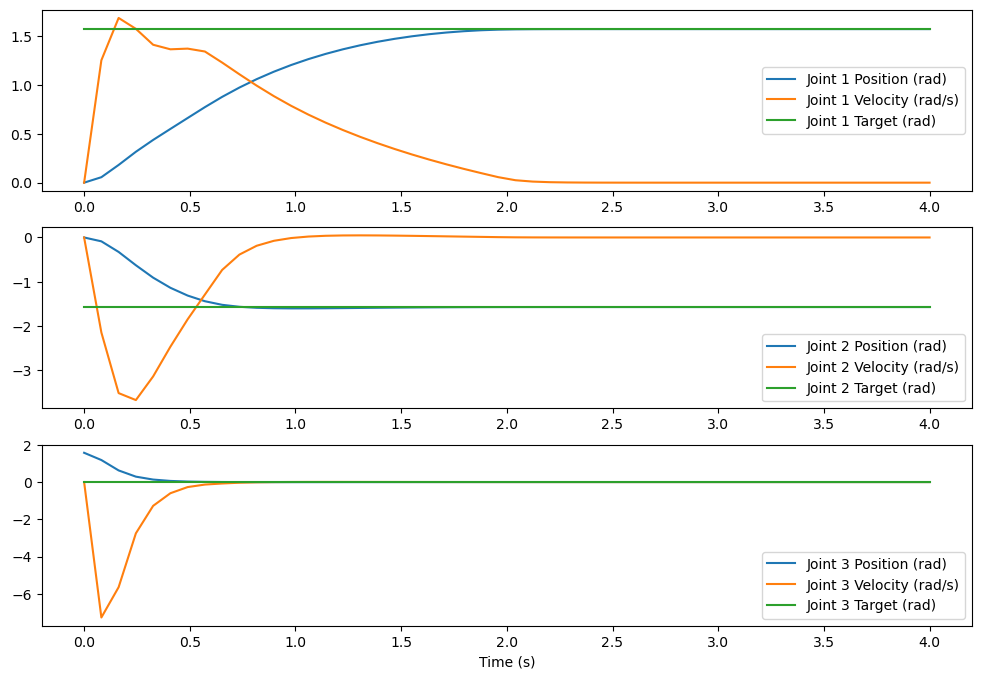

In [285]:

# Plot the results
plt.figure(figsize=(12, 8))
for i in range(ndim):
    plt.subplot(3, 1, i+1)
    plt.plot(t, y[i], label=f'Joint {i+1} Position (rad)')
    plt.plot(t, y[i+3], label=f'Joint {i+1} Velocity (rad/s)')
    plt.plot(t, [q_d[i]]*len(t), label=f'Joint {i+1} Target (rad)')
    plt.legend()
plt.xlabel('Time (s)')
plt.show()

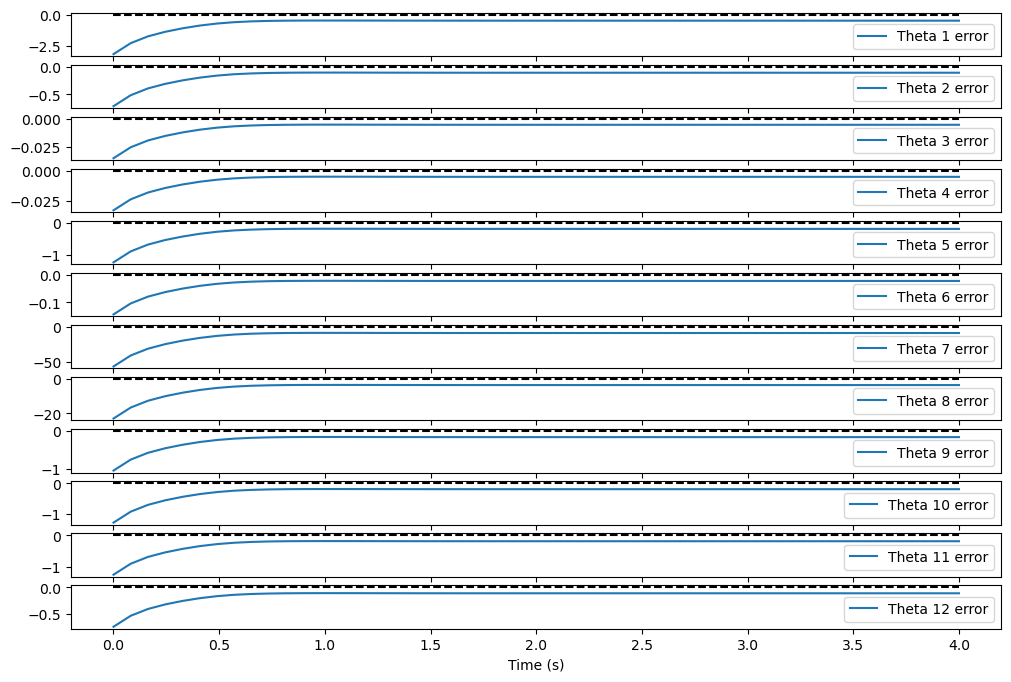

Text(0.5, 0, 't')

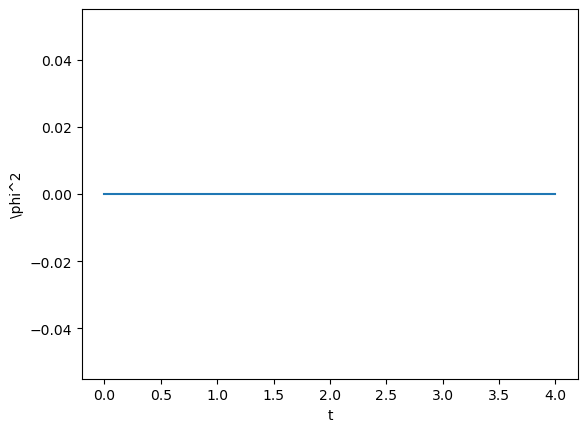

In [286]:
# Assimilation error dynamics
pdim = len(theta_hat0)
# Plot the results
plt.figure(figsize=(12, 8))
for i in range(pdim):
    plt.subplot(pdim, 1, i+1)
    plt.plot(t, y[2*ndim+i] - [theta[i]]*len(t), label=f'Theta {i+1} error')
    plt.plot(t, [0]*len(t), 'k--') #, label=f'Theta {i+1} error' )
    # plt.plot(t, [theta[i]]*len(t), label=f'Theta {i+1} true')
    plt.legend()
plt.xlabel('Time (s)')
plt.show()

# Phi computation  
Yf_list = []
phi = []
for idx, tt in enumerate(t):
    Yf_list.append( y[2*ndim + pdim:2*ndim+pdim + (nfilter * ndim)*pdim][:,idx].reshape((nfilter * ndim, pdim)) )
    phi.append(np.linalg.det(Yf_list[-1]))


phi2t = np.power(phi,2)

plt.plot(t,phi2t)
plt.ylabel('\phi^2')
plt.xlabel('t')
    

In [252]:
phit

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [253]:
Yf_list[-1]

array([[ 6.79523638e-06,  1.52420292e-06,  7.50514202e-08,
         6.94172485e-08,  2.61000350e-06,  3.04883107e-07,
         1.20819817e-04,  4.90245232e-05,  2.23166355e-06,
         2.76393332e-06,  2.65762820e-06,  1.59457692e-06],
       [-3.76782290e-06, -8.45140088e-07, -4.16145140e-08,
        -3.84904783e-08, -1.44719483e-06, -1.69051595e-07,
        -6.69921764e-05, -2.71831193e-05, -1.23741288e-06,
        -1.53254584e-06, -1.47360177e-06, -8.84161063e-07],
       [-5.22414449e-08, -1.17179975e-08, -5.76991648e-10,
        -5.33676411e-10, -2.00655792e-08, -2.34392641e-09,
        -9.28856847e-07, -3.76898136e-07, -1.71569202e-08,
        -2.12489842e-08, -2.04317156e-08, -1.22590293e-08],
       [ 1.22027447e+01,  2.73713203e+00,  1.34775786e-01,
         1.24658057e-01,  4.68699021e+00,  5.47502767e-01,
         2.16965725e+02,  8.80372231e+01,  4.00757517e+00,
         4.96341420e+00,  4.77251366e+00,  2.86350819e+00],
       [-1.88460168e+00, -4.22724866e-01, -2.0814880

In [280]:
# Example usage
A = np.array([[1, 2, 3], [0, 4, 5], [1, 0, 6]])
A = Yf_list[-1]
adjugate_A = compute_adjugate(A)
print("Adjugate of A:\n", adjugate_A)
A @ adjugate_A

Adjugate of A:
 [[-2.77146403e-62  9.69588638e-62 -1.16350637e-60 -1.81891998e-76
  -7.52862394e-77 -3.08511154e-75 -1.32956299e-75 -5.38385280e-76
  -3.67287171e-75 -7.33001611e-76 -4.84871941e-75  1.17502615e-74]
 [ 1.47428459e-62 -2.12542695e-61 -5.66780520e-61 -3.69587705e-77
   1.52416543e-76  1.42737576e-74  8.81338022e-76  1.40480653e-75
   1.54606325e-75  6.28874803e-76  8.82722300e-75 -3.39097085e-74]
 [ 3.99447287e-60 -2.15087001e-59  2.88831115e-58  4.42976074e-74
   1.37786850e-73  6.29497304e-73  2.05430559e-73  1.59984723e-73
   2.86192073e-73  2.11179322e-73  9.05555297e-73 -2.28799790e-72]
 [ 3.07003384e-60 -1.13174976e-59  1.65989965e-58  9.07581387e-75
   8.99062711e-74  4.19443187e-73  9.13736861e-74  9.76357616e-74
   2.75933831e-73  1.01414075e-73  5.52902184e-73 -1.63535186e-72]
 [-1.58389024e-61  9.00751493e-61 -1.18498863e-59 -1.64779169e-75
  -4.91694004e-75 -1.91208963e-74 -7.32071194e-75 -5.83472952e-75
  -9.41565255e-75 -6.09409963e-75 -3.72669567e-74  9.458

array([[ 4.61100146e-67,  3.59449231e-65, -7.46906116e-64,
        -8.82461725e-80,  3.49722309e-79,  4.52091362e-78,
        -1.28483280e-78,  1.78542829e-79, -9.01374837e-79,
         1.66975171e-79, -2.28872931e-78, -1.70801998e-78],
       [-2.24935525e-67, -1.75347811e-65,  3.64358417e-64,
         4.30485640e-80, -1.70602789e-79, -2.20540828e-78,
         6.26771740e-79, -8.70974024e-80,  4.39711902e-79,
        -8.14544258e-80,  1.11649613e-78,  8.33212426e-79],
       [-2.08568160e-68, -1.62588681e-66,  3.37845988e-65,
         3.99161484e-81, -1.58188930e-80, -2.04493242e-79,
         5.81164886e-80, -8.07597865e-81,  4.07716400e-80,
        -7.55274195e-81,  1.03525463e-79,  7.72583978e-80],
       [ 6.55595954e-53,  5.11067852e-51, -1.06195722e-49,
        -1.25469129e-65,  4.97238035e-65,  6.42787190e-64,
        -1.82678577e-64,  2.53853652e-65, -1.28158210e-64,
         2.37406661e-65, -3.25413403e-64, -2.42847676e-64],
       [-2.51506234e-53, -1.96060927e-51,  4.0739857

In [281]:

np.linalg.det(A)

2.5898682481099402e-79